# Battle of Neighborhoods, Amsterdam

### Background

Amsterdam is the capital city of the Netherlands, with a population of around 2.4 million in the metropolitan area. The city also is the commercial and cultural capital of the Netherlands and is considered an alpha- world city. Amsterdam is also one of the most popular tourist destinations in Europe, receiving more than 4.63 million international visitors annually. Along with Frankfurt, the city is one of the gateways to Europe for travelers from the East.

With the influx of travelers to the city increasing by every year, there has also been a surge in the number of places of accommodation to cater to the increasing demand. Along with the traditional options like hotels and lodgings, cheaper and flexible alternatives like Airbnb stays and hostels have become more popular among tourists. This leaves the travelers with myriad of options to choose from but at the same time present a dilemma in deciding which location serves them best considering all factors like affordability, proximity to places of interest etc.


### Business Problem

The project attempts to provides the travelers to Amsterdam with a comprehensive comparison of different neighborhoods of the city to help them in deciding the location of their stay based on their preferences. To solve the problem, we will be using the Airbnb listing data for Amsterdam along with the location data from Foursquare API listing the happening venues around the neighbourhood of stay. The project targets mainly solo travelers and back-packers who, it is presumed, would benefit the most from the exercise.

## Data

As the main data set, we will be using the Airbnb listing for Amsterdam available [here](https://www.kaggle.com/erikbruin/airbnb-amsterdam#listings.csv) and list of neighbourhoods of Amsterdam available [here](https://www.kaggle.com/erikbruin/airbnb-amsterdam#neighbourhoods.csv) on Kaggle website. A snippet from the full data set is shown below.

Let us first import the required libraries

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 

from geopy.geocoders import Nominatim 

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         238 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

In [67]:
#laoding the dataframe
Amsterdam_AB_DF = pd.read_csv("Amsterdam_AB_Data.csv")
Amsterdam_AB_DF.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,28-11-18,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,NaN,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,29-08-18,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,NaN,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,30-11-18,2.18,2,198
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,NaN,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,21-01-18,0.09,2,141
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.386727,4.892078,Private room,150,2,171,25-11-18,2.03,1,199


### Data cleaning and exploratory data analysis

Let's find out the number of listings by last reviewed year and remove inactive records

In [68]:
import datetime
pd.to_datetime(Amsterdam_AB_DF.last_review).dt.year.value_counts()

2018.0    13208
2017.0     2725
2016.0     1276
2015.0      356
2014.0       43
2013.0       11
2012.0        4
2011.0        1
Name: last_review, dtype: int64

In [69]:
#Keep only records which were reviewd after 2018 .
Amsterdam_AB_DF=Amsterdam_AB_DF[pd.to_datetime(Amsterdam_AB_DF.last_review).dt.year>=2018]

We will also remove listing with zero reviews and any listing where the minimum stay required is more than a week

In [70]:
Amsterdam_AB_DF=Amsterdam_AB_DF[Amsterdam_AB_DF.minimum_nights<=7]

In [71]:
Amsterdam_AB_DF=Amsterdam_AB_DF[Amsterdam_AB_DF.number_of_reviews>=1]

As we are mainly targeting solo travelers and backpackers, who are more likely to go for single and shared rooms rather than full apartments, we work with a subset of the full data set and all full apartment listings will be removed

In [72]:
Amsterdam_AB_DF=Amsterdam_AB_DF[Amsterdam_AB_DF['room_type'].isin( ['Private room','Shared room'])]

We will investigate the price column now and remove zero values and outliers

In [75]:
Amsterdam_AB_DF.price.describe()

count    2944.000000
mean       99.760530
std        56.895963
min        20.000000
25%        69.000000
50%        87.000000
75%       119.000000
max       950.000000
Name: price, dtype: float64

In [64]:
Amsterdam_AB_DF=Amsterdam_AB_DF[Amsterdam_AB_DF.price<2000]
Amsterdam_AB_DF=Amsterdam_AB_DF[Amsterdam_AB_DF.price != 0]

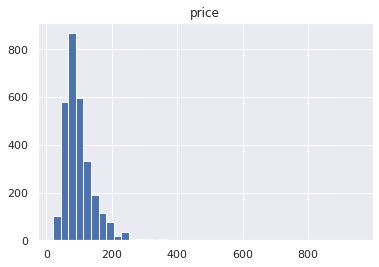

In [85]:
%matplotlib inline
from matplotlib import pyplot as plt
Amsterdam_AB_DF.hist(column='price',bins=40)
plt.show()

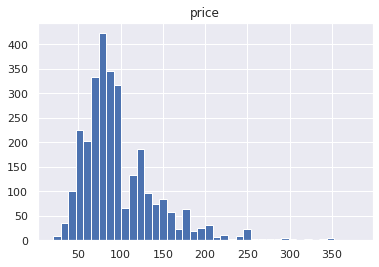

In [86]:
%matplotlib inline
from matplotlib import pyplot as plt
Amsterdam_AB_DF[Amsterdam_AB_DF.price<400].hist(column='price',bins=40)
plt.show()

Now we derive three relevant features from this data set
1. number_of_listings
1. avg_price
1. avg_review_count

In [79]:
DF_Final=Amsterdam_AB_DF.groupby('neighbourhood').agg({'id':'count','price':'mean','number_of_reviews':'mean'})
DF_Final.columns = ['number_of_listings','avg_price','avg_review_count']
DF_Final

,number_of_listings,avg_price,avg_review_count
neighbourhood,,,
Bijlmer-Centrum,33,67.757576,50.848485
Bijlmer-Oost,42,62.285714,39.000000
Bos en Lommer,140,79.507143,61.900000
Buitenveldert - Zuidas,35,77.457143,45.371429
Centrum-Oost,312,122.153846,73.689103
Centrum-West,513,130.553606,77.306043
De Aker - Nieuw Sloten,46,77.760870,69.804348
De Baarsjes - Oud-West,382,92.007853,66.926702
De Pijp - Rivierenbuurt,248,94.088710,73.637097


Let's visualize these on bar chart

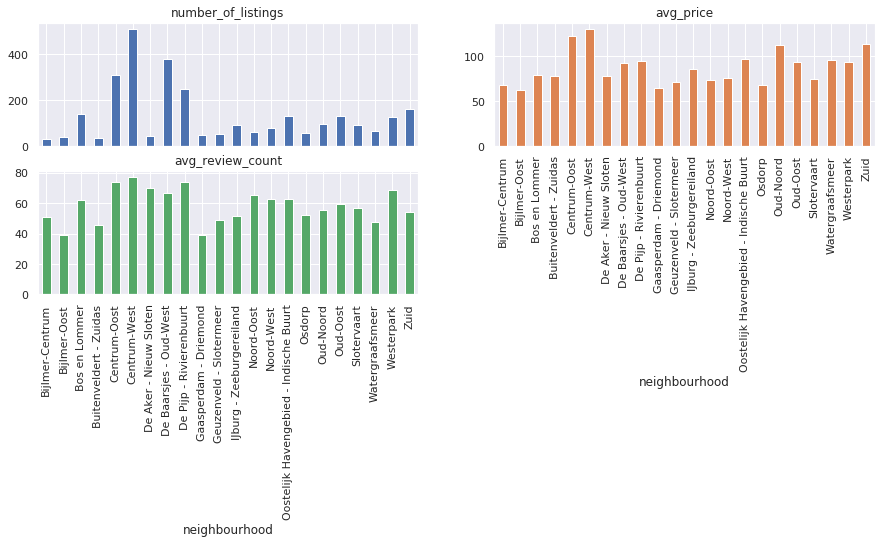

In [81]:
DF_Final.plot(kind='bar',figsize=(15,5) ,subplots=True, layout=(2,2),legend=None)
plt.show()

Now let's explore the neighborhoods in Amsterdam on map. For this we need the coordinates of the neighborhoods of Amsterdam. We will use the Nominatim library to get the coordinates wherever possible. If the API doesn't return the coordinates for the neighborhood, we will use the mean coordinates of the neighborhood from the Airbnb data.

In [29]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [30]:
import pandas as pd 
import numpy as np 
Amsterdam_NBH= pd.read_csv("neighbourhoods.csv")
Amsterdam_NBH.head()
 

,neighbourhood_group,neighbourhood
0,NaN,Bijlmer-Centrum
1,NaN,Bijlmer-Oost
2,NaN,Bos en Lommer
3,NaN,Buitenveldert - Zuidas
4,NaN,Centrum-Oost


In [87]:
# Find out the mean coordinates of the neighborhoods to fill if Nominatim doesnt return the coordinates
nb_new=Amsterdam_AB_DF.groupby('neighbourhood')['latitude','longitude'].mean().reset_index()

In [32]:
nb_new.columns =['Neighborhood', 'Latitude', 'Longitude']
nb_new

,Neighborhood,Latitude,Longitude
0,Bijlmer-Centrum,52.316856,4.950433
1,Bijlmer-Oost,52.320765,4.976127
2,Bos en Lommer,52.378958,4.851225
3,Buitenveldert - Zuidas,52.330824,4.870415
4,Centrum-Oost,52.366238,4.900161
5,Centrum-West,52.375072,4.889504
6,De Aker - Nieuw Sloten,52.346685,4.796534
7,De Baarsjes - Oud-West,52.366571,4.863235
8,De Pijp - Rivierenbuurt,52.351044,4.897800
9,Gaasperdam - Driemond,52.300361,4.987937


Bringing in the coordinates using Nominatim and using the mean coordinates for Nans

In [33]:
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 
AMS_NB_DF = pd.DataFrame(columns=column_names)
for nb in Amsterdam_NBH.neighbourhood:
    geolocator = Nominatim(user_agent="AMS_explorer")
    location = geolocator.geocode(nb +', Amsterdam')
    if location is None:
        latitude=max(nb_new[nb_new.Neighborhood==nb]['Latitude'])
        longitude=max(nb_new[nb_new.Neighborhood==nb]['Longitude'])
    else:
        latitude = location.latitude
        longitude = location.longitude
    AMS_NB_DF=AMS_NB_DF.append({'Neighborhood': nb,
                                          'Latitude': latitude,
                                          'Longitude': longitude
                     }, ignore_index=True)
AMS_NB_DF

,Neighborhood,Latitude,Longitude
0,Bijlmer-Centrum,52.316856,4.950433
1,Bijlmer-Oost,52.320765,4.976127
2,Bos en Lommer,52.378521,4.848738
3,Buitenveldert - Zuidas,52.336262,4.860970
4,Centrum-Oost,52.358983,4.924509
5,Centrum-West,52.373730,4.895691
6,De Aker - Nieuw Sloten,52.350632,4.783183
7,De Baarsjes - Oud-West,52.366571,4.863235
8,De Pijp - Rivierenbuurt,52.346579,4.917350
9,Gaasperdam - Driemond,52.312666,4.989188


As we have the coordinates of all neighborhoods by now, we will first display them on a map of Amsterdam. Lets first install folium maps to create the map

In [34]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [88]:
# Getting the coordinaes of Amsterdam for the map to center
from geopy.geocoders import Nominatim
address = 'Amsterdam, Netherlands'
geolocator = Nominatim(user_agent="Amsterdam")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [89]:
# Creating a map of neighborhoods
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, neighborhood in zip(AMS_NB_DF['Latitude'], AMS_NB_DF['Longitude'], AMS_NB_DF['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

Now we include the coordinates in the dataset

In [82]:
DF_Final.reset_index(inplace=True)
DF_Final

,neighbourhood,number_of_listings,avg_price,avg_review_count
0,Bijlmer-Centrum,33,67.757576,50.848485
1,Bijlmer-Oost,42,62.285714,39.000000
2,Bos en Lommer,140,79.507143,61.900000
3,Buitenveldert - Zuidas,35,77.457143,45.371429
4,Centrum-Oost,312,122.153846,73.689103
5,Centrum-West,513,130.553606,77.306043
6,De Aker - Nieuw Sloten,46,77.760870,69.804348
7,De Baarsjes - Oud-West,382,92.007853,66.926702
8,De Pijp - Rivierenbuurt,248,94.088710,73.637097
9,Gaasperdam - Driemond,48,64.270833,39.291667


In [83]:
DF_Final2=DF_Final.join(AMS_NB_DF[['Latitude','Longitude']],how='inner')
DF_Final2

,neighbourhood,number_of_listings,avg_price,avg_review_count,Latitude,Longitude
0,Bijlmer-Centrum,33,67.757576,50.848485,52.316856,4.950433
1,Bijlmer-Oost,42,62.285714,39.000000,52.320765,4.976127
2,Bos en Lommer,140,79.507143,61.900000,52.378521,4.848738
3,Buitenveldert - Zuidas,35,77.457143,45.371429,52.336262,4.860970
4,Centrum-Oost,312,122.153846,73.689103,52.358983,4.924509
5,Centrum-West,513,130.553606,77.306043,52.373730,4.895691
6,De Aker - Nieuw Sloten,46,77.760870,69.804348,52.350632,4.783183
7,De Baarsjes - Oud-West,382,92.007853,66.926702,52.366571,4.863235
8,De Pijp - Rivierenbuurt,248,94.088710,73.637097,52.346579,4.917350
9,Gaasperdam - Driemond,48,64.270833,39.291667,52.312666,4.989188


Now we are going to leverage the Foursquare location data to bring in the venues around each neighborhood. For this analysis we have identified the below main venue categories of interest to tourists. There are many subcategories under each of the categories, the main category “Food” for example, has subcategories like Chinese restaurant, Turkish restaurant etc. We will bring in up to 100 venues with in 800m of the neighborhoods.
1. Arts & Entertainment
2. Food
3. Nightlife Spot
4. Outdoors & Recreation
5. Shop & Service

In [90]:
CLIENT_ID = 'K0AKGGALTEX31E55HZXD3BU2B5HE3TWVAXTM3EF2R5MJEM0T' 
CLIENT_SECRET = 'XEI34W1LH5EJW0G3RDVAPIUXYP11HPR04JNNNPYVKUUQ3JXT' 
VERSION = '20191015'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K0AKGGALTEX31E55HZXD3BU2B5HE3TWVAXTM3EF2R5MJEM0T
CLIENT_SECRET:XEI34W1LH5EJW0G3RDVAPIUXYP11HPR04JNNNPYVKUUQ3JXT


From the Foursqaure website, we obtain the category ids of the venues of our interest and create a dictionary of it.

In [40]:
main_cat_tourists={'4d4b7104d754a06370d81259':'Arts & Entertainment',
'4d4b7105d754a06374d81259':'Food',
'4d4b7105d754a06376d81259':'Nightlife Spot',
'4d4b7105d754a06377d81259':'Outdoors & Recreation',
'4d4b7105d754a06378d81259':'Shop & Service'}


In [41]:
#Creating a function bring in the venues using Foursqaure API. 
def getNearbyVenues(names, latitudes, longitudes,main_category, radius):
    
    venues_list=[]
    LIMIT = 100
    radius = 800
    for name, lat, lng  in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT,
   main_category
    
)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            main_cat_tourists[main_category]) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                   'Main Category']
    
    return(nearby_venues)

We will run our function in a loop for each category and get the venue information



In [42]:
column_names = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue',  
                'Venue Latitude', 'Venue Longitude', 
            'Venue Category',
                   'Main Category']
neighborhood_venues_all = pd.DataFrame(columns=column_names)
for k in main_cat_tourists:
    neighborhood_venues=getNearbyVenues(names=DF_Final2['neighbourhood'],
    latitudes=DF_Final2['Latitude'],
    longitudes=DF_Final2['Longitude'],
    main_category = k)
    neighborhood_venues_all = pd.concat([neighborhood_venues_all,neighborhood_venues],ignore_index=True)

In [99]:
neighborhood_venues_all.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Main Category
0,Bijlmer-Centrum,52.316856,4.950433,ArenA Stadium Tour,52.313624,4.940329,Tour Provider,Arts & Entertainment
1,Bijlmer-Centrum,52.316856,4.950433,AFAS Live,52.312320,4.944220,Concert Hall,Arts & Entertainment
2,Bijlmer-Centrum,52.316856,4.950433,Pathé Arena,52.312579,4.945553,Multiplex,Arts & Entertainment
3,Bijlmer-Centrum,52.316856,4.950433,iMax 3D,52.312561,4.945510,Movie Theater,Arts & Entertainment
4,Bijlmer-Centrum,52.316856,4.950433,Ajax Museum,52.313184,4.940563,Museum,Arts & Entertainment


Next, we find out the count of venues of each category for all neighborhoods and combine this with the feature set we derived from Airbnb data set to prepare the final data set to cluster.

In [100]:
df_venue=neighborhood_venues_all.groupby(['Neighborhood','Main Category'])['Venue'].count().reset_index()
df_venue.head()

,Neighborhood,Main Category,Venue
0,Bijlmer-Centrum,Arts & Entertainment,23
1,Bijlmer-Centrum,Food,61
2,Bijlmer-Centrum,Nightlife Spot,16
3,Bijlmer-Centrum,Outdoors & Recreation,21
4,Bijlmer-Centrum,Shop & Service,76


In [101]:
df_venue2=df_venue.pivot_table(index='Neighborhood',columns ='Main Category',values='Venue').reset_index()
df_cluster=DF_Final2.join(df_venue2)[['Neighborhood','Latitude','Longitude','number_of_listings','avg_price','avg_review_count','Arts & Entertainment',
                   'Food','Nightlife Spot','Outdoors & Recreation','Shop & Service']]
df_cluster.fillna(0,inplace=True)
df_cluster.head()

,Neighborhood,Latitude,Longitude,number_of_listings,avg_price,avg_review_count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,Bijlmer-Centrum,52.316856,4.950433,33,67.757576,50.848485,23.0,61.0,16.0,21.0,76.0
1,Bijlmer-Oost,52.320765,4.976127,42,62.285714,39.000000,9.0,9.0,3.0,4.0,15.0
2,Bos en Lommer,52.378521,4.848738,140,79.507143,61.900000,9.0,41.0,6.0,25.0,46.0
3,Buitenveldert - Zuidas,52.336262,4.860970,35,77.457143,45.371429,6.0,35.0,6.0,23.0,15.0
4,Centrum-Oost,52.358983,4.924509,312,122.153846,73.689103,12.0,69.0,26.0,26.0,76.0


# Clustering

Before clustering, the feature are normalized using a min-max normalization algorithm

In [102]:
from sklearn import preprocessing
df_to_cluster = df_cluster.drop(['Neighborhood','Latitude','Longitude'], 1)
x = df_to_cluster.to_numpy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_to_cluster = pd.DataFrame(x_scaled)
df_to_cluster

,0,1,2,3,4,5,6,7
0,0.000000,0.080153,0.309311,0.355932,0.593750,0.16,0.339286,0.750000
1,0.018750,0.000000,0.000000,0.118644,0.052083,0.03,0.035714,0.114583
2,0.222917,0.252262,0.597817,0.118644,0.385417,0.06,0.410714,0.437500
3,0.004167,0.222234,0.166330,0.067797,0.322917,0.06,0.375000,0.114583
4,0.581250,0.876959,0.905578,0.169492,0.677083,0.26,0.428571,0.750000
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,0.910714,1.000000
6,0.027083,0.226683,0.804164,0.050847,0.000000,0.02,0.000000,0.083333
7,0.727083,0.435375,0.729042,0.338983,1.000000,0.39,0.696429,0.968750
8,0.447917,0.465856,0.904220,0.033898,0.343750,0.06,0.303571,0.218750
9,0.031250,0.029078,0.007614,0.016949,0.000000,0.02,0.053571,0.000000


The value of K is conveniently chosen to be 3 as we have only 21 neighborhoods to cluster and in order not to enforce the algorithm to create a cluster of one or two neighborhoods alone if we select a higher value of K

In [103]:

kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_to_cluster)

kmeans.labels_[0:21] 

array([2, 0, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2],
      dtype=int32)

In [106]:
#Putting the cluster label into the dtaset
df_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [107]:
df_cluster

,Cluster Labels,Neighborhood,Latitude,Longitude,number_of_listings,avg_price,avg_review_count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,2,Bijlmer-Centrum,52.316856,4.950433,33,67.757576,50.848485,23.0,61.0,16.0,21.0,76.0
1,0,Bijlmer-Oost,52.320765,4.976127,42,62.285714,39.000000,9.0,9.0,3.0,4.0,15.0
2,2,Bos en Lommer,52.378521,4.848738,140,79.507143,61.900000,9.0,41.0,6.0,25.0,46.0
3,0,Buitenveldert - Zuidas,52.336262,4.860970,35,77.457143,45.371429,6.0,35.0,6.0,23.0,15.0
4,2,Centrum-Oost,52.358983,4.924509,312,122.153846,73.689103,12.0,69.0,26.0,26.0,76.0
5,1,Centrum-West,52.373730,4.895691,513,130.553606,77.306043,61.0,100.0,100.0,53.0,100.0
6,0,De Aker - Nieuw Sloten,52.350632,4.783183,46,77.760870,69.804348,5.0,4.0,2.0,2.0,12.0
7,1,De Baarsjes - Oud-West,52.366571,4.863235,382,92.007853,66.926702,22.0,100.0,39.0,41.0,97.0
8,2,De Pijp - Rivierenbuurt,52.346579,4.917350,248,94.088710,73.637097,4.0,37.0,6.0,19.0,25.0
9,0,Gaasperdam - Driemond,52.312666,4.989188,48,64.270833,39.291667,3.0,4.0,2.0,5.0,4.0


In [108]:
clusters=df_cluster.groupby('Cluster Labels')['Neighborhood'].apply(lambda x:', '.join (x)).reset_index()

In [109]:
clusters.to_csv ('Clusters.csv', index = None, header=True)

Let's visualize the resulting clusters

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon,poi,listing,avp,food,nl, cluster, Art, Outdoor,Shops in zip(df_cluster['Latitude'], df_cluster['Longitude'], 
                                df_cluster['Neighborhood'],
                                  df_cluster['number_of_listings'],
                                  df_cluster['avg_price'],
                                  df_cluster['Food'],
                                  df_cluster['Nightlife Spot'],
                                  df_cluster['Cluster Labels'],
                                df_cluster['Arts & Entertainment'],
                     df_cluster['Outdoors & Recreation'],
                                                     df_cluster['Shop & Service']):
    label = folium.Popup('Neighborhood: '+str(poi) + ', Cluster ' + str(cluster)+',\n' 
                         'Listings: ' +str(int(listing))+',\n' 
                         'Avg Price: ' +str(int(avp))+',\n' 
                         'Food Spots: ' +str(int(food))+',\n' 
                         'Nightlife Spots : ' +str(int(nl))+',\n' 
                         'Entertainment Spots :' +str(int(Art))+',\n' 
                         'Recreation Spots :'+str(int(Outdoor))+',\n' 
                         'Shops & Services :'+str(int(food))+',\n' 
                         , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine the clusters

We start by plotting the feature values on bar charts and examine

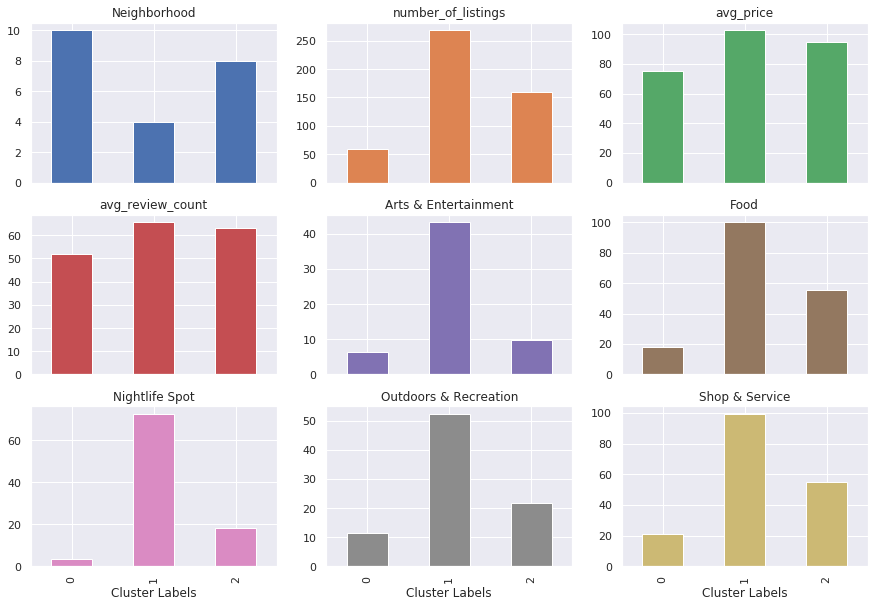

<Figure size 432x288 with 0 Axes>

In [111]:
df_cluster.groupby('Cluster Labels').agg({'Neighborhood':'count',
                                        'number_of_listings':'mean',
                                          'avg_price':'mean','avg_review_count':'mean',
                                         'Arts & Entertainment':'mean',
                                         'Food':'mean',
                                         'Nightlife Spot':'mean',
                                         'Outdoors & Recreation':'mean',
                                         'Shop & Service':'mean'}).plot(kind='bar',figsize=(15,10)
                                                                      ,subplots=True,
                                                                       layout=(3,3),legend=None)
plt.show()
plt.tight_layout()

A swarm plot is created to visualize how the feature values vary among neighborhoods within each cluster


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

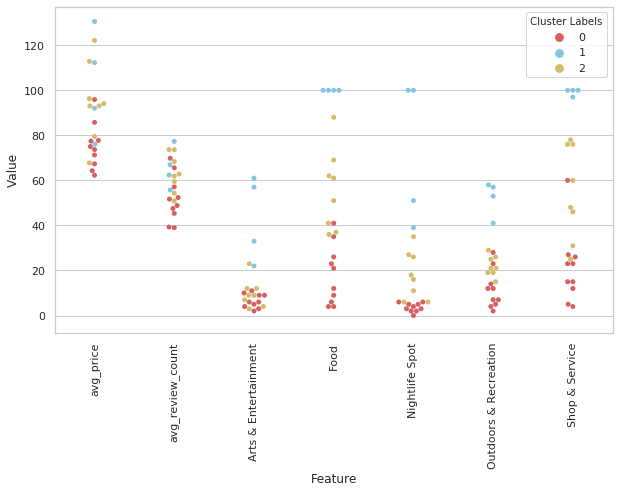

In [112]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted")
fig, ax =plt.subplots(figsize=(10, 6))


cluster_unpivot = pd.melt(df_cluster, id_vars=['Cluster Labels','Neighborhood'], value_vars=['avg_price','avg_review_count','Arts & Entertainment',
                   'Food','Nightlife Spot','Outdoors & Recreation','Shop & Service'], var_name="Feature",
               value_name='Value')
# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="Feature", y="Value", hue="Cluster Labels",
              palette=["r", "c", "y"], data=cluster_unpivot)
plt.xticks(rotation='vertical')

Now we create a feature heatmap of all clusters to to identify which feature intensive each neighborhood within the cluster is. For this, we need to normalize the features first as they are in different scales.

In [113]:
df_cluster_normalized=df_cluster
for col in ['number_of_listings','avg_price','avg_review_count','Arts & Entertainment',
                   'Food','Nightlife Spot','Outdoors & Recreation','Shop & Service']:
    max_value = df_cluster_normalized[col].max()
    min_value = df_cluster_normalized[col].min()
    df_cluster_normalized[col] = (df_cluster_normalized[col] - min_value) / (max_value - min_value)
df_cluster_normalized



,Cluster Labels,Neighborhood,Latitude,Longitude,number_of_listings,avg_price,avg_review_count,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,2,Bijlmer-Centrum,52.316856,4.950433,0.000000,0.080153,0.309311,0.355932,0.593750,0.16,0.339286,0.750000
1,0,Bijlmer-Oost,52.320765,4.976127,0.018750,0.000000,0.000000,0.118644,0.052083,0.03,0.035714,0.114583
2,2,Bos en Lommer,52.378521,4.848738,0.222917,0.252262,0.597817,0.118644,0.385417,0.06,0.410714,0.437500
3,0,Buitenveldert - Zuidas,52.336262,4.860970,0.004167,0.222234,0.166330,0.067797,0.322917,0.06,0.375000,0.114583
4,2,Centrum-Oost,52.358983,4.924509,0.581250,0.876959,0.905578,0.169492,0.677083,0.26,0.428571,0.750000
5,1,Centrum-West,52.373730,4.895691,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,0.910714,1.000000
6,0,De Aker - Nieuw Sloten,52.350632,4.783183,0.027083,0.226683,0.804164,0.050847,0.000000,0.02,0.000000,0.083333
7,1,De Baarsjes - Oud-West,52.366571,4.863235,0.727083,0.435375,0.729042,0.338983,1.000000,0.39,0.696429,0.968750
8,2,De Pijp - Rivierenbuurt,52.346579,4.917350,0.447917,0.465856,0.904220,0.033898,0.343750,0.06,0.303571,0.218750
9,0,Gaasperdam - Driemond,52.312666,4.989188,0.031250,0.029078,0.007614,0.016949,0.000000,0.02,0.053571,0.000000


### Cluster 0

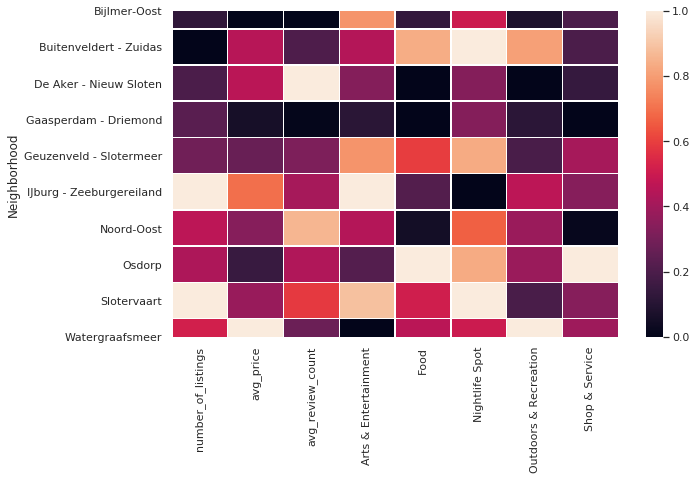

In [114]:
import seaborn as sns

df_cluster0_normalized=df_cluster[df_cluster['Cluster Labels']==0].iloc[:,[1,4,5,6,7,8,9,10,11]].set_index('Neighborhood')
df_cluster0_normalized
for col in ['number_of_listings','avg_price','avg_review_count','Arts & Entertainment',
                   'Food','Nightlife Spot','Outdoors & Recreation','Shop & Service']:
    max_value = df_cluster0_normalized[col].max()
    min_value = df_cluster0_normalized[col].min()
    df_cluster0_normalized[col] = (df_cluster0_normalized[col] - min_value) / (max_value - min_value)
df_cluster0_normalized
sns.set()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_cluster0_normalized, fmt="f", linewidths=.5, ax=ax)
plt.show()

### Cluster 1

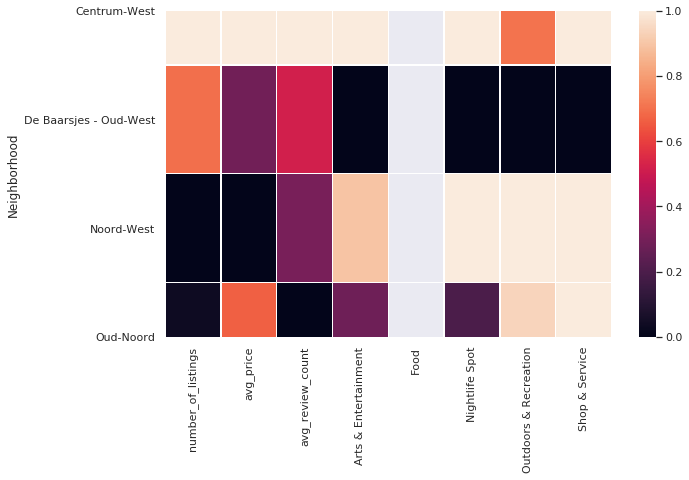

In [115]:
df_cluster1_normalized=df_cluster[df_cluster['Cluster Labels']==1].iloc[:,[1,4,5,6,7,8,9,10,11]].set_index('Neighborhood')
for col in ['number_of_listings','avg_price','avg_review_count','Arts & Entertainment',
                   'Food','Nightlife Spot','Outdoors & Recreation','Shop & Service']:
    max_value = df_cluster1_normalized[col].max()
    min_value = df_cluster1_normalized[col].min()
    df_cluster1_normalized[col] = (df_cluster1_normalized[col] - min_value) / (max_value - min_value)
sns.set()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_cluster1_normalized, fmt="f", linewidths=.5, ax=ax)
plt.show()

### Cluster 2

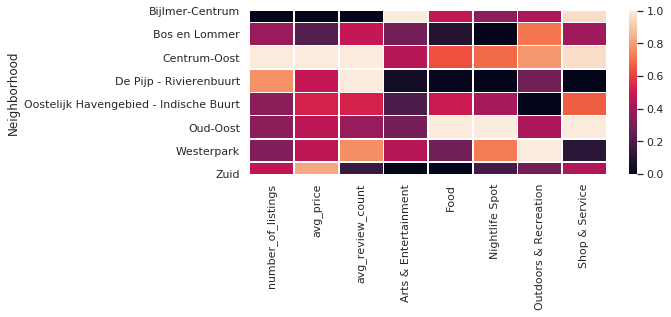

In [116]:
df_cluster2_normalized=df_cluster[df_cluster['Cluster Labels']==2].iloc[:,[1,4,5,6,7,8,9,10,11]].set_index('Neighborhood')
for col in ['number_of_listings','avg_price','avg_review_count','Arts & Entertainment',
                   'Food','Nightlife Spot','Outdoors & Recreation','Shop & Service']:
    max_value = df_cluster2_normalized[col].max()
    min_value = df_cluster2_normalized[col].min()
    df_cluster2_normalized[col] = (df_cluster2_normalized[col] - min_value) / (max_value - min_value)
sns.set()
f, ax = plt.subplots(figsize=(8, 3))
hm2 = sns.heatmap(df_cluster2_normalized, fmt="f", linewidths=.5, ax=ax)
plt.savefig("hm2.png")
hm2
plt.show()